# X-ray spectral fitting with nested sampling using BXA
In this tutorial we will use [BXA](https://johannesbuchner.github.io/BXA/) working within [Sherpa](https://cxc.cfa.harvard.edu/sherpa/) in order to performe spectral fitting of the spectrum of M86 tULX-1, the Ultra Luminous X-ray source that we discussed in the lecture. We will then use the estimation of the evidence (tha comes for free during the nested sampling) to decide which particular spectral model is more suitable for this particular object. We will need to following imports:

In [1]:
import bxa.sherpa as bxa
from sherpa.astro import ui
from astropy.coordinates import SkyCoord
from astropy import units as u
import pyvo as vo
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from ciao_contrib.runtool import search_csc

We will be using the [che2gehrels](https://cxc.cfa.harvard.edu/sherpa/statistics/#chigehrels) statistic, that is appropiated for the Poisson regime with low counts. In Sherpa, we can set the statistic using *set_stat*:

In [2]:
ui.set_stat('chi2gehrels')

We now set the spectral units to energy, as opposed to wavelneght:

In [3]:
ui.set_analysis('ener')

We are interested in a source, M86 tULX-1, that is close to galaxy M86 in the Virgo cluster. We perform a conce search of the Chandra Source Catalog around the location of M86, and then print a table with the results.

In [4]:
M86 = SkyCoord.from_name('M86')
maxrad = 4.0 * u.arcmin

In [5]:
cone = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch')

In [6]:
results = cone.search(pos=M86, radius=maxrad, verbosity=2)

In [7]:
tbl = results.to_table()

In [8]:
tbl

name,ra,dec,err_ellipse_r0,conf_flag,extent_flag,sat_src_flag,flux_aper_b,flux_aper_lolim_b,flux_aper_hilim_b,flux_aper_w,flux_aper_lolim_w,flux_aper_hilim_w,significance,hard_hm,hard_hm_lolim,hard_hm_hilim,hard_ms,hard_ms_lolim,hard_ms_hilim,var_intra_index_b,var_intra_index_w,var_inter_index_b,var_inter_index_w
,deg,deg,arcsec,,,,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,,,,,,,,,,,
object,float64,float64,float64,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32
2CXO J122559.2+125615,186.49702059575282,12.937768041839554,2.1481374176416215,0,0,0,3.8867803444458e-15,1.7274579308648e-15,5.9597298614835e-15,--,--,--,2.711111111111003,-0.086196127420362,-0.41536539662711,0.23297938788257,-0.19862585883823,-0.49406620861961,0.50281074328545,0,--,5,--
2CXO J122559.9+125647,186.49968993982225,12.946499620505046,3.529388846968554,0,1,0,4.7301306684229e-15,2.5469934368431e-15,6.9132679000026e-15,--,--,--,1.999999999999984,0.21986258588382,-0.36039975015615,0.93254216114928,-0.99937539038101,-1.0,-0.72891942535915,0,--,5,--
2CXO J122600.5+125805,186.50240393640274,12.968305217176383,2.8518004147586247,0,1,0,1.9863649187971e-15,1.0329097577745e-15,2.9000927814438e-15,--,--,--,3.1904761904761867,0.10618363522798,-0.22298563397876,0.43910056214866,-0.54965646470956,-0.78513429106808,-0.23422860712055,0,--,--,--
2CXO J122602.0+125401,186.50848964689408,12.900515822914379,2.352004058456732,0,0,0,0.0,0.0,1.445723074245e-15,--,--,--,2.368421052631495,--,--,--,--,--,--,1,--,5,--
2CXO J122602.2+125757,186.50920495146556,12.966005612571715,2.579941429984686,0,0,0,6.1578747513535e-15,4.3729835190771e-15,7.9427659836299e-15,--,--,--,2.9714285714285404,0.66083697688944,0.38538413491568,0.89006870705809,-0.80824484697064,-0.98376014990631,-0.51280449718926,--,--,6,--
2CXO J122602.3+125951,186.5096540843474,12.997532274456194,0.7315855739300802,0,1,0,1.1764381013821e-13,1.1383641880986e-13,1.2145120146656e-13,--,--,--,31.12390014369071,0.0037476577139288,-0.031855090568395,0.039350405996252,-0.24109931292942,-0.27795128044972,-0.20174890693317,0,--,--,--
2CXO J122603.5+125658,186.5149014626627,12.949655898369537,0.741723021919465,1,1,0,4.4342402307448e-15,3.3614401749194e-15,5.5070402865702e-15,--,--,--,4.216216216216538,0.25983760149906,0.094316052467208,0.42535915053092,-0.22361024359775,-0.42161149281699,0.0031230480949407,1,--,7,--
2CXO J122605.7+125642,186.52381069940952,12.945026446494484,0.8469062876244915,0,0,0,0.0,0.0,1.0094923322994e-15,--,--,--,2.4864864864863367,--,--,--,--,--,--,0,--,5,--


The source of interest, M86 tULX-1 is located at (186.5096540843474, 12.997532274456194), and so we use those coordinates to download the spectral files using *search_csc*. The spectral files are three files:

* The PHA (Pulse Height Amplitude) file, which is basically a histogram of counts per energy bin, or the "raw" spectrum.
* The RMF (Redistribution Matrix) file, which maps from energy space to pulse heights in the detector. This is necessary because detectors are imperfect, and counts are spread in space due to the limited resolution. 
* The ARF (Auxiliary Response) that contains the effective area and quantum efficiencies as a function of energy and averaged over time

In [9]:
search_csc('186.5096540843474, 12.997532274456194', '5', 'source_search.tsv', 'arcsec', 
           '', '', 'all', '/Users/juan/L3/tutorial', 'broad', 'pha,rmf,arf', 'csc2','1','1')

search_csc
             pos = 186.5096540843474, 12.997532274456194
          radius = 5
         outfile = source_search.tsv
         radunit = arcsec
         columns = 
     sensitivity = no
        download = all
            root = /Users/juan/L3/tutorial
           bands = broad
       filetypes = pha,rmf,arf
         catalog = csc2
         verbose = 1
         clobber = yes
            mode = hl


1 rows returned by query
1 Different Master Source(s).
1 Different Observation(s).

name                	ra          	dec         	sepn	obsid	
 2CXO J122602.3+125951	1.865097e+02	1.299753e+01	0"	15149	
Retrieving files for obsid_obi 15149_000

We now load the spectrum we just downloaded.

In [10]:
ui.load_pha('/Users/juan/L3/tutorial/2CXOJ122602.3+125951/15149_000/acisf15149_000N022_r0014_pha3.fits')

read ARF file /Users/juan/L3/tutorial/2CXOJ122602.3+125951/15149_000/acisf15149_000N021_r0014_arf3.fits
read RMF file /Users/juan/L3/tutorial/2CXOJ122602.3+125951/15149_000/acisf15149_000N021_r0014_rmf3.fits
read background file /Users/juan/L3/tutorial/2CXOJ122602.3+125951/15149_000/acisf15149_000N022_r0014_pha3.fits


We will ignore energies below 0.5 keV and above 8 keV, which we know are energy regions with low spectral response. We subtract the background, and then plot the resulting X-ray spectrum.

In [11]:
ui.ignore('0.:0.5,8.0:')
ui.subtract()

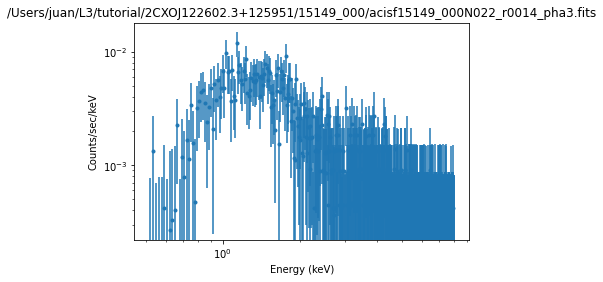

In [12]:
ui.set_ylog()
ui.set_xlog()
ui.plot_data()

## Setting the spectral models
We now set the spectral model. For a description of all the spectral models available in Sherpa, see: [Sherpa Models](https://cxc.cfa.harvard.edu/sherpa/models/). Initially we will use a power law spectral model that is a good choice for the non-thermal emission from the ULX. We know that there is photoelectric absorption of the X-rays from material between the source and us, and so we apply an absorption component to the model. We also set a hard minimu for the amplitude of the power law, and set the hydrogen atom density to a value [suitable](https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/w3nh/w3nh.pl) to this region of the sky:

In [13]:
ui.set_source('xsphabs.abs1 * powlaw1d.p1')

In [14]:
p1.ampl.min = 1E-3

abs1.nH = 0.0262
ui.freeze(abs1.nH)

In [15]:
ui.show_model()

Model: 1
apply_rmf(apply_arf((148067.11139156 * (xsphabs.abs1 * powlaw1d.p1))))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   abs1.nH      frozen       0.0262            0       100000 10^22 atoms / cm^2
   p1.gamma     thawed            1          -10           10           
   p1.ref       frozen            1 -3.40282e+38  3.40282e+38           
   p1.ampl      thawed            1        0.001  3.40282e+38           



We can use the *guess* function in Sherpa to get an initial guess of the model parameters (this will make it easier for the model to converge later):

In [16]:
ui.guess(p1)

In [17]:
ui.show_model()

Model: 1
apply_rmf(apply_arf((148067.11139156 * (xsphabs.abs1 * powlaw1d.p1))))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   abs1.nH      frozen       0.0262            0       100000 10^22 atoms / cm^2
   p1.gamma     thawed            1          -10           10           
   p1.ref       frozen            1 -3.40282e+38  3.40282e+38           
   p1.ampl      thawed  2.76305e-05  2.76305e-08    0.0276305           



## Setting the probabilistic model with BXA
We now set the probabilistic model by setting the priors and starting a solver. Note that we do not need to define a likelihood, as we have already stated early on that we will use a particular statistic (chi2reghels) that directly links to the likelihood.

In [18]:
# parameters we want to vary
param1 = p1.gamma
param2 = p1.ampl

# list of parameters
parameters = [param1, param2]
# list of prior transforms
priors = [
   bxa.create_uniform_prior_for(param1),
   bxa.create_loguniform_prior_for(param2),
]

# make a single function:
priorfunction = bxa.create_prior_function(priors)

Note that the solver will also provide the final value of the evidence Z. We can use this number to compare between models. This is where the power of statistics helps us compare models and decide which model is better at describing the data.

In [20]:
# see the pymultinest documentation for all options
solver = bxa.BXASolver(prior=priorfunction, parameters=parameters,
             outputfiles_basename = "myoutputs30/")
results = solver.run(resume=True)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7e+01   [-67.2694..-67.2694]*| it/evals=4640/6525 eff=75.7551% N=400  0 00  0 0 0 
[ultranest] Likelihood function evaluations: 6544
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -76.38 +- 0.1001
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.10 tail:0.08 total:0.13 required:<0.50
[ultranest] done iterating.

logZ = -76.361 +- 0.263
  single instance: logZ = -76.361 +- 0.143
  bootstrapped   : logZ = -76.382 +- 0.250
  tail           : logZ = +- 0.080
insert order U test : converged: True correlation: inf iterations

    p1.gamma            : 1.579 │ ▁▁▁▁▁▁▁▁▂▃▃▄▆▅▆▇▇▇▇▇▇▆▄▄▃▂▁▁▁▁▁▁▁▁▁ ▁ │2.293     1.916 +- 0.092
    p1.ampl             : 0.0000189│ ▁ ▁▁▁▁▁▁▁▁▂▂▃▅▅▄▅▆▇▇▆▇▇▅▄▅▃▂▂▁▁▁▁▁▁▁▁ │0.0000309    

We can plot the spectra with the best fit (or MAP estimate, the solution that maximizes the posterior):

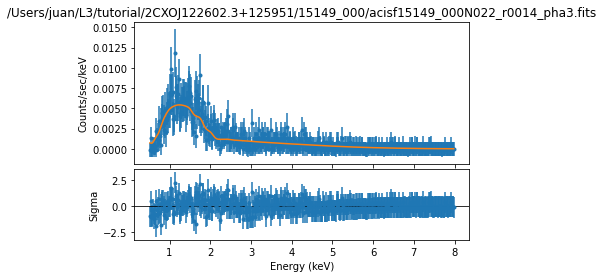

In [21]:
ui.set_ylinear()
ui.set_xlinear()
ui.plot_fit_delchi(xlog=False, ylog=False)

### Disk model
We can now try a different model. We are going to assume that emission is of thermal nature, and comes from the accretion disk around the black hole. There is a Sherpa model for a blackbody disk, to which we also add a photoelectric absorption coefficient:

In [25]:
ui.set_source('xsphabs.abs1 * xsdiskbb.p1')
p1.norm.min = 1E-5

In [26]:
ui.show_model()

Model: 1
apply_rmf(apply_arf((148067.11139156 * (xsphabs.abs1 * xsdiskbb.p1))))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   abs1.nH      frozen       0.0262            0       100000 10^22 atoms / cm^2
   p1.Tin       thawed            1            0         1000        keV
   p1.norm      thawed            1        1e-05        1e+24           



In [28]:
# parameters we want to vary
param1 = p1.Tin
param2 = p1.norm
#param3 = abs1.nH

# list of parameters
parameters = [param1, param2]
# list of prior transforms
priors = [
   bxa.create_uniform_prior_for(param1),
   bxa.create_loguniform_prior_for(param2),
]

# make a single function:
priorfunction = bxa.create_prior_function(priors)

In [30]:
# see the pymultinest documentation for all options
solver = bxa.BXASolver(prior=priorfunction, parameters=parameters,
             outputfiles_basename = "myoutputs31/")
results = solver.run(resume=True)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-6e+01   [-63.3176..-63.3172]*| it/evals=6692/12952 eff=53.2903% N=397    0 00 0 0 00 0 
[ultranest] Likelihood function evaluations: 12969
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -77.93 +- 0.1365
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.11 total:0.17 required:<0.50
[ultranest] done iterating.

logZ = -77.923 +- 0.375
  single instance: logZ = -77.923 +- 0.185
  bootstrapped   : logZ = -77.929 +- 0.359
  tail           : logZ = +- 0.107
insert order U test : converged: True correlation: inf iterations

    p1.Tin              : 0.602 │ ▁▁▁▁▁▁▁▂▂▃▃▆▅▆▇▇▇▇▆▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁ ▁ │1.183     0.858 +- 0.070
    p1.norm             : 0.0018│ ▁▁▁▂▄▆▆▇▇▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁  ▁ │0.0299    

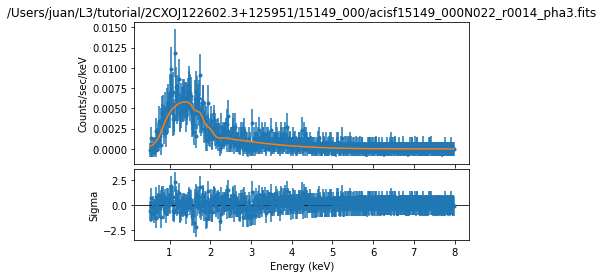

In [31]:
ui.set_ylinear()
ui.set_xlinear()
ui.plot_fit_delchi(xlog=False, ylog=False)

Finally, let's try a combination of both models. Which moel has the largest evidence?

In [45]:
ui.set_source('xsphabs.abs1 * (powlaw1d.p1 + xsdiskbb.p2)')
p2.norm.min = 1E-5
p2.norm = 0.008
p1.ampl.min =  1E-10
p1.ampl = 2.5E-5

In [46]:
ui.show_model()

Model: 1
apply_rmf(apply_arf((148067.11139156 * (xsphabs.abs1 * (powlaw1d.p1 + xsdiskbb.p2)))))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   abs1.nH      frozen       0.0262            0       100000 10^22 atoms / cm^2
   p1.gamma     thawed            1          -10           10           
   p1.ref       frozen            1 -3.40282e+38  3.40282e+38           
   p1.ampl      thawed      2.5e-05        1e-10  3.40282e+38           
   p2.Tin       thawed            1        1e-05         1000        keV
   p2.norm      thawed        0.008        1e-05        1e+24           



In [47]:
#ui.guess(p1)

In [48]:
# parameters we want to vary
param1 = p1.gamma
param2 = p1.ampl
param3 = p2.Tin
param4 = p2.norm
#param3 = abs1.nH

# list of parameters
parameters = [param1, param2, param3, param4]
# list of prior transforms
priors = [
   bxa.create_gaussian_prior_for(param1, 2, 0.5),
   bxa.create_loguniform_prior_for(param2),
   bxa.create_gaussian_prior_for(param3, 0.8, 0.3),
   bxa.create_loguniform_prior_for(param4),
   
   # and more priors
]

# make a single function:
priorfunction = bxa.create_prior_function(priors)

In [49]:
# see the pymultinest documentation for all options
solver = bxa.BXASolver(prior=priorfunction, parameters=parameters,
             outputfiles_basename = "myoutputs33/")
results = solver.run(resume=True)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-6e+01   [-62.1013..-62.1012]*| it/evals=6120/190464 eff=3.2200% N=400    0 0 0 0  0 
[ultranest] Likelihood function evaluations: 190464
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -72.7 +- 0.08408
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.08 tail:0.01 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -72.679 +- 0.130
  single instance: logZ = -72.679 +- 0.148
  bootstrapped   : logZ = -72.700 +- 0.130
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    p1.gamma            : 0.31  │ ▁▁▁▁▁▁▁▂▂▃▃▅▆▇▆▇▇▇▆▅▄▃▄▃▂▂▁▁▁▁▁▁▁▁  ▁ │3.96      1.93 +- 0.48
    p1.ampl             : 0.0000000│▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ │0.0000295  

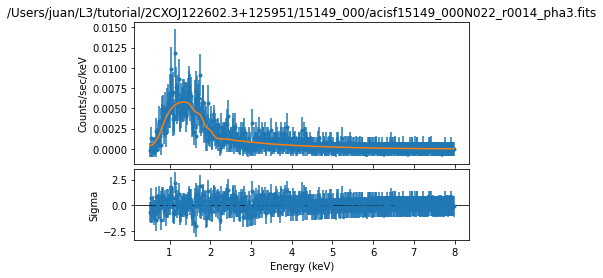

In [50]:
ui.set_ylinear()
ui.set_xlinear()
ui.plot_fit_delchi(xlog=False, ylog=False)